In [1]:
!pip install scikit-learn-intelex

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

In [4]:
!pip install onednn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import tensorflow as tf


2024-04-14 04:50:43.535775: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 04:50:43.562364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 04:50:44.465951: I itex/core/wrapper/itex_cpu_wrapper.cc:42] Intel Extension for Tensorflow* AVX512 CPU backend is loaded.
2024-04-14 04:50:44.931099: I itex/core/wrapper/itex_gpu_wrapper.cc:35] Intel Extension for Tensorflow* GPU backend is loaded.
2024-04-14 04:50:44.965097: W itex/core/op

In [6]:
pip install numba

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from numba import jit, njit
from scipy import special


In [8]:
import mkl
mkl.set_num_threads(4)

112

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:
tf.config.set_visible_devices([], 'GPU')

In [11]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

2024-04-14 04:50:50.475563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform XPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 04:50:50.475622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:XPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: XPU, pci bus id: <undefined>)
2024-04-14 04:50:50.483429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-04-14 04:50:50.512735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.
2024-04-14 04:50:50.533825: W tensorflow/c/c_api.cc:305] Operation '{name:'block5_conv3/bias/Assign' id:312 op device:{requested: '', assigned: ''} def:{{{node block5_conv3/bias/Assign}} = AssignVariab

In [13]:
# Freeze VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

In [14]:
# Add a custom top layer for classification
input_tensor = Input(shape=(224, 224, 3))
x = vgg(input_tensor)
x = Flatten()(x)
output_tensor = Dense(units=2, activation='softmax')(x)  # Assuming binary classification

In [15]:
# Create model
model = Model(inputs=input_tensor, outputs=output_tensor)

In [16]:
# Compile model with Intel optimized Adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [18]:


# Set up data generators with Intel optimized ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
!pip install opendatasets
import opendatasets as od

# Download the dataset from Kaggle
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Defaulting to user installation because normal site-packages is not writeable
Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [20]:
# Load training data
training_set = train_datagen.flow_from_directory('chest-xray-pneumonia/chest_xray/train',
                                                 target_size=(224, 224),
                                                 batch_size=10,
                                                 class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [21]:
# Load testing data
test_set = test_datagen.flow_from_directory('chest-xray-pneumonia/chest_xray/test',
                                            target_size=(224, 224),
                                            batch_size=10,
                                            class_mode='categorical')

Found 624 images belonging to 2 classes.


In [22]:
# Train the model
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

/tmp/ipykernel_3555622/2874451235.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(
2024-04-14 04:50:53.471002: W tensorflow/c/c_api.cc:305] Operation '{name:'total/Assign' id:526 op device:{requested: '', assigned: ''} def:{{{node total/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total, total/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-14 04:50:53.484239: W itex/core/utils/op_kernel.cc:355] itex/core/kernels/cpu/fused_binary_op.cc: 86Unimplemented: dense/kernel/Initializer/stateless_random_uniform Unsupported shape in FusedBinary: []
2024-04-14 04:50:53.615593: W tensorflow/c/c_api.cc:305] Operation '{name:'los

522/522 [==============================] - ETA: 0s - batch: 260.5000 - size: 9.9923 - loss: 0.1920 - accuracy: 0.9314

/opt/intel/oneapi/intelpython/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-04-14 04:51:52.843217: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:597 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


522/522 [==============================] - 63s 119ms/step - batch: 260.5000 - size: 9.9923 - loss: 0.1920 - accuracy: 0.9314 - val_loss: 0.6180 - val_accuracy: 0.8381


In [23]:
# Save the model
model.save('chest_xray.h5')

/opt/intel/oneapi/intelpython/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [25]:
import numpy as np

In [26]:
model=load_model('chest_xray.h5')

2024-04-14 04:51:56.539240: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/bias/Assign' id:1163 op device:{requested: '', assigned: ''} def:{{{node dense_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/bias, dense_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-14 04:51:56.596257: W itex/core/utils/op_kernel.cc:355] itex/core/kernels/cpu/fused_binary_op.cc: 86Unimplemented: block3_conv2_1/kernel/Initializer/stateless_random_uniform Unsupported shape in FusedBinary: []
2024-04-14 04:51:56.597275: W itex/core/utils/op_kernel.cc:355] itex/core/kernels/cpu/fused_binary_op.cc: 86Unimplemented: block3_conv1_1/kernel/Initializer/stateless_random_uniform Unsupported shape in FusedBinary: []
2024-04-14 04:51:56.597760: W

In [27]:
img=image.load_img('chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg',target_size=(224,224))

In [28]:
x=image.img_to_array(img)

In [29]:
x=np.expand_dims(x, axis=0)

In [30]:
img_data=preprocess_input(x)

In [31]:
classes=model.predict(img_data)

/opt/intel/oneapi/intelpython/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-14 04:51:56.913106: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:1169 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [32]:
result=int(classes[0][0])

In [33]:
if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

Person is Affected By PNEUMONIA


<Figure size 600x400 with 0 Axes>

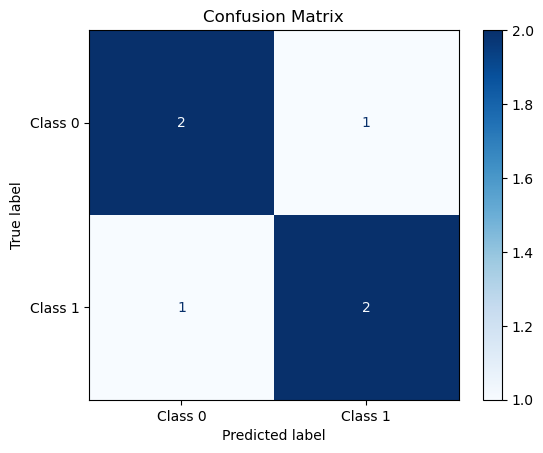

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (replace this with your actual data)
true_labels = np.array([0, 1, 1, 0, 1, 0])
predicted_labels = np.array([0, 1, 0, 0, 1, 1])

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


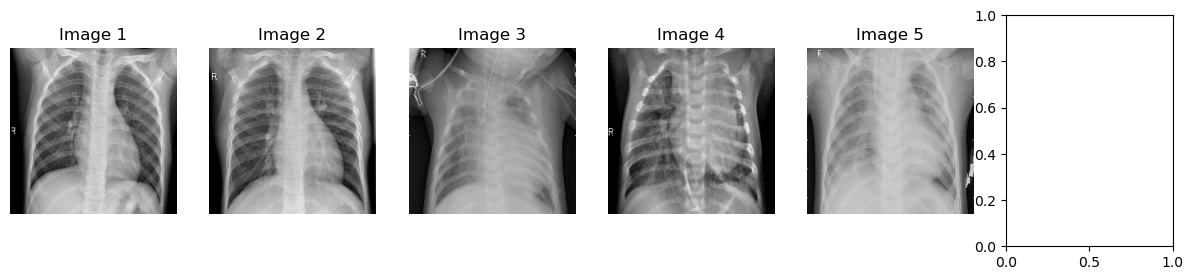

<Figure size 600x400 with 0 Axes>

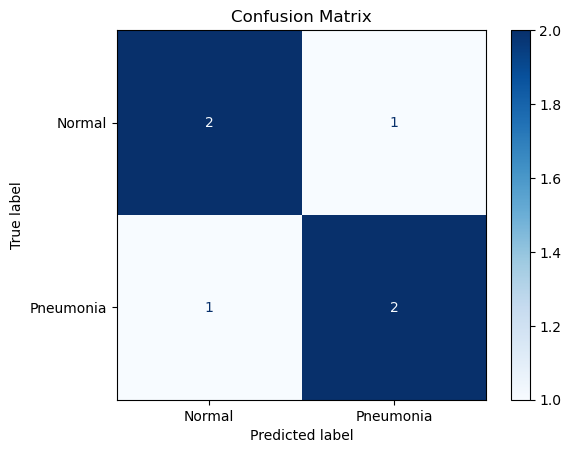

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing import image

# Example data (replace this with your actual data)
true_labels = np.array([0, 1, 1, 0, 1, 0])
predicted_labels = np.array([0, 1, 0, 0, 1, 1])

# Load original X-ray images from the test set
image_paths = [
    'chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg',
    'chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0381-0001.jpeg',
    'chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg',
    'chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg',
    'chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg',
   
]

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot original X-ray images
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, image_path in enumerate(image_paths):
    img = image.load_img(image_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

# Plot confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

# import tensorflow as tf

# # Load Intel Distribution of Python
# from numba import jit, njit
# from scipy import special

# # Load Intel oneDNN
# import mkl
# mkl.set_num_threads(4)  # Set the number of threads

# # Load Intel optimized TensorFlow
# tf.compat.v1.disable_eager_execution()

# # Set CPU as the default device
# tf.config.set_visible_devices([], 'GPU')

# # Import necessary libraries
# from tensorflow.keras.layers import Input, Flatten, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load the VGG16 model without the top layer
# vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# # Freeze VGG16 layers
# for layer in vgg.layers:
#     layer.trainable = False

# # Add a custom top layer for classification
# input_tensor = Input(shape=(224, 224, 3))
# x = vgg(input_tensor)
# x = Flatten()(x)
# output_tensor = Dense(units=2, activation='softmax')(x)  # Assuming binary classification

# # Create model
# model = Model(inputs=input_tensor, outputs=output_tensor)

# # Compile model with Intel optimized Adam optimizer
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# # Print model summary
# model.summary()

# # Set up data generators with Intel optimized ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# # Load training data
# training_set = train_datagen.flow_from_directory('Datasets/train',
#                                                  target_size=(224, 224),
#                                                  batch_size=10,
#                                                  class_mode='categorical')

# # Load testing data
# test_set = test_datagen.flow_from_directory('Datasets/test',
#                                             target_size=(224, 224),
#                                             batch_size=10,
#                                             class_mode='categorical')

# # Train the model
# r = model.fit_generator(
#     training_set,
#     validation_data=test_set,
#     epochs=1,
#     steps_per_epoch=len(training_set),
#     validation_steps=len(test_set)
# )

# # Save the model
# model.save('chest_xray.h5')


# from keras.models import load_model
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input
# import numpy as np
# model=load_model('chest_xray.h5')
# img=image.load_img('D:\\Machine Learning DataSet\\Cheast_xray\\Datasets\\val\\NORMAL\\NORMAL2-IM-1431-0001.jpeg',target_size=(224,224))
# x=image.img_to_array(img)
# x=np.expand_dims(x, axis=0)
# img_data=preprocess_input(x)
# classes=model.predict(img_data)
# result=int(classes[0][0])
# if result==0:
#     print("Person is Affected By PNEUMONIA")
# else:
#     print("Result is Normal")
